# Portfolio Optimization with Linear Programming
Refrence: https://vanderbei.princeton.edu/307/lectures/lec3_show.pdf

In [2]:
import sys, os 
import pandas as pd 
import numpy as np 
import datetime

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline 

### Data collected through Alpha Vantage API

In [3]:
data_path = sys.path[0]+"/ETF_Data/"
ETF_list = os.listdir(data_path)
ETF_list.sort()
print(ETF_list[:10])

['AAAU.xlsx', 'AADR.xlsx', 'AAXJ.xlsx', 'ACES.xlsx', 'ACIM.xlsx', 'ACSG.xlsx', 'ACSI.xlsx', 'ACT.xlsx', 'ACWF.xlsx', 'ACWI.xlsx']


### Select assets and time windows

In [4]:
# Import data and format 
asset_1 = pd.read_excel(data_path+ETF_list[6]) # 2018-08-15, 2019-07-09
asset_2 = pd.read_excel(data_path+ETF_list[33]) # 2010-07-21, 2019-07-09
asset_3 = pd.read_excel(data_path+ETF_list[353]) # 2016-08-22, 2019-07-09

asset_1 = asset_1.set_index(pd.DatetimeIndex(asset_1["date"]))
asset_2 = asset_2.set_index(pd.DatetimeIndex(asset_2["date"]))
asset_3 = asset_3.set_index(pd.DatetimeIndex(asset_3["date"]))

# Select time window
# 2018-08-20 to 2019-05-31, then check return over june 2019
start = "2019-02-01"
end = "2019-05-31"

asset_1 = asset_1.truncate(before=start, after=end)
asset_2 = asset_2.truncate(before=start, after=end)
asset_3 = asset_3.truncate(before=start, after=end)

asset_1 = asset_1["5. adjusted close"] # ASCI
asset_2 = asset_2["5. adjusted close"] # ALFA
asset_3 = asset_3["5. adjusted close"] # EMFM

In [4]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=asset_1.index, y=asset_1,
                    mode='lines+markers',
                    name='ASCI'))
fig.add_trace(go.Scatter(x=asset_2.index, y=asset_2,
                    mode='lines+markers',
                    name='ALFA'))
fig.add_trace(go.Scatter(x=asset_3.index, y=asset_3,
                    mode='lines+markers',
                    name='EMFM'))
fig.show()

### Get Monthly Returns 

In [5]:
# Get monthly returns 
a1_returns = asset_1.resample('M').mean()
a1_returns = np.diff(a1_returns.values)
print(a1_returns)

a2_returns = asset_2.resample('M').mean()
a2_returns = np.diff(a2_returns.values)
print(a2_returns)

a3_returns = asset_3.resample('M').mean()
a3_returns = np.diff(a3_returns.values)
print(a3_returns)

[ 0.25712381  0.90099048 -0.29633247]
[ 2.04398596  2.1274619  -0.46384524]
[ 1.87578296  4.08471429 -2.04481255]


### Plot Monthly Returns

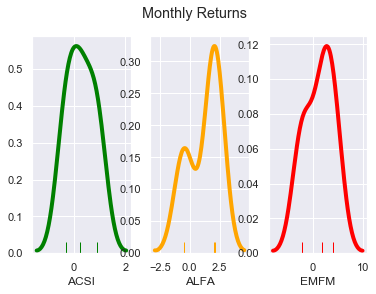

In [6]:
# Plot monthly returns
fig, axs = plt.subplots(ncols=3)
fig.suptitle("Monthly Returns", fontsize="x-large")

ax1 = sns.distplot(a1_returns, hist=False, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},rug = True,ax=axs[0])
ax1.set(xlabel="ACSI")

ax2 = sns.distplot(a2_returns, hist=False, kde=True, 
             bins=int(180/5), color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},rug = True,ax=axs[1])
ax2.set(xlabel="ALFA")

ax3 = sns.distplot(a3_returns, hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'blue'},
             kde_kws={'linewidth': 4},rug = True,ax=axs[2])
ax3.set(xlabel="EMFM")

plt.draw()
plt.savefig("MonthlyReturns")

### Average Returns and Risk

In [7]:
T = len(a1_returns)

reward_1 = (1/T) * np.sum(a1_returns)
reward_2 = (1/T) * np.sum(a2_returns)
reward_3 = (1/T) * np.sum(a3_returns)

risk_1 = (1/T) * np.sum(np.abs(a1_returns - reward_1))
risk_2 = (1/T) * np.sum(np.abs(a2_returns - reward_2))
risk_3 = (1/T) * np.sum(np.abs(a3_returns - reward_3))


## Portfolio Thoery

minimize &emsp; $\sigma_p(w) = \sqrt{w^TVw}$ <br>
s.t. &emsp; $w^Te=1$ &ensp; and &ensp; $w^T\boldsymbol{\mu} = \mu $ <br>

$V$ &emsp;  is a covraiance matrix  <br>
$w$ &emsp;  weight vector expressing allocation to each asset <br>
$\boldsymbol{\mu}$ &emsp; mean vector with average return of each asset

## Portfolio Theory Linear Programming Formated

max &ensp; $ \frac{1}{T}\sum^T_{t=1}\sum_{j} x_j R_j (t)$ <br> 

s.t. &ensp; $ -y_t \leq \sum_j x_j (R_j(t) - \text{reward}_j) \leq y_t$  &ensp; for all "t" <br>


$
\begin{matrix}
    \frac{1}{T}\sum^T_{t=1} y_t \leq \mu \\
    \sum_j x_j =1 \\
\end{matrix}
$

&emsp; $x_j$ $\geq 0$ &ensp; for all j  &emsp; $y_t$ $\geq 0$ &ensp; for all t<br>

In [8]:
from pulp import *

def optimize_portfolio(R,rewards,mu = 1,delta_mu = .001, steps = 100):
    weights, risk = [], []
    
    for i in range(steps):
        prob = LpProblem("Portfolio Allocation", LpMaximize)

        # Create x variables 
        x_var = []
        for i in range(len(R)):
            x_var.append(LpVariable("x"+str(i), 0))

        # Create y variables 
        y_vars = []
        for t in range(T):
            y_t = LpVariable("y_"+str(t),0)
            y_vars.append(y_t)

        # The objective function
        opt_function_var = []
        for a in range(len(rewards)):
            for b in range(len(R[0])):
                opt_function_var.append( (a,a,b) )
            
        prob += lpSum([x_var[i]*R[j][k]  for (i,j,k) in opt_function_var])

        # Constraint functions   
        for t in range(T):
            prob += lpSum([x_var[i] * (R[i][t]-rewards[i]) for i in range(len(x_var))]) <= y_vars[t]
            prob += lpSum([x_var[i] * (R[i][t]-rewards[i]) for i in range(len(x_var))]) >= -1*y_vars[t]
            
        prob += (1/T)*lpSum(y_vars) <= mu 
        prob += lpSum([x_var[i] for i in range(len(x_var))]) == 1 

        # Solve problem
        prob.solve()
        if pulp.LpStatus[prob.status] == "Optimal":
            temp_weights = []
            for i in range(len(x_var)): temp_weights.append(x_var[i].varValue)
            weights.append(temp_weights)
            risk.append(mu)
        
        mu = mu + delta_mu
        
    return weights, risk        
    

In [9]:
# Evaluate for range of mu values ~ risk value
rewards = [reward_1.tolist(),reward_2.tolist(),reward_3.tolist()]
R = [a1_returns.tolist(),a2_returns.tolist(),a3_returns.tolist()]
weights, risk = optimize_portfolio(R,rewards,mu = .01,delta_mu = .001, steps = 600)

## Plot Sudo Efficient Frontier

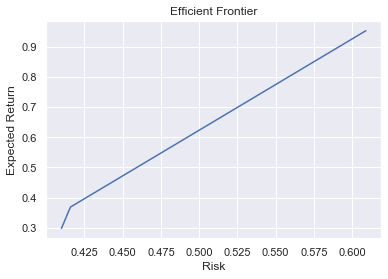

In [10]:
reward_values = []
for i in range(len(weights)):
    reward_values.append(reward_1*weights[i][0] + reward_2*weights[i][1] + reward_3*weights[i][1])
    
plt.plot(risk,reward_values)
plt.title("Efficient Frontier")
plt.xlabel("Risk")
plt.ylabel("Expected Return")
plt.draw()
plt.savefig("LinearEfficientFronteir")